<a href="https://colab.research.google.com/github/GGpark1/Deep_Learning_Study/blob/master/%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98(MLP%2C%20DTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

다층 퍼셉트론과 DTM으로 텍스트 분류하기

In [35]:
#모듈 import

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [4]:
newsdata_train = fetch_20newsgroups(subset = 'train')
newsdata_test = fetch_20newsgroups(subset = 'test')

In [9]:
#feature 확인

print(newsdata_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [16]:
#타겟 데이터 클래스 수 확인

print(f"타겟 클래수 수 : {len(set(newsdata_train.target))}")
print(f"타겟 이름 : {newsdata_train.target_names}")

타겟 클래수 수 : 20
타겟 이름 : ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [22]:
#dataFrame 구성

df = pd.DataFrame(newsdata_train.data, columns = ['text'])
df['target'] = pd.Series(newsdata_train.target)
df.head()

,text,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


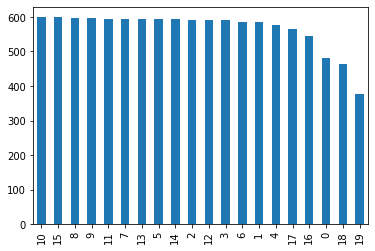

In [24]:
#타겟 분포 확인

df['target'].value_counts().plot(kind='bar');

In [25]:
#데이터 스플릿

X_train = df['text']
y_train = df['target']
X_test = newsdata_test.data
y_test = newsdata_test.target

In [28]:
#데이터 전처리 함수

vocab_size = 10000 #빈도 순으로 10,000개의 단어만 토큰화하여 사용
num_classes = 20

def prepare_data(X_train, X_test, mode):
    tokenizer = Tokenizer(num_words = vocab_size) #10,000개의 단어만 사용하는 tokenizer 클래스 정의
    tokenizer.fit_on_texts(X_train) #X_train 데이터셋 토큰화
    X_train_enco = tokenizer.texts_to_matrix(X_train, mode = mode) #DTM 생성
    X_test_enco = tokenizer.texts_to_matrix(X_test, mode = mode)

    return X_train_enco, X_test_enco, tokenizer.index_word


In [29]:
X_train_enco, X_test_enco, index_to_word = prepare_data(X_train, X_test, 'binary')

In [37]:
#다층 퍼셉트론 설계

def fit_and_evaluate(X_train_enco, y_train, X_test_enco, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
    #하나의 sample씩 병렬로 신경망에 입력됨. 이때 입력되는 데이터의 크기는 행 하나의 벡터 사이즈임
    #전체 데이터셋에서 봤을 땐(1, 10000)이지만, 샘플 하나를 떼어넣고 보면 (10000,)임 
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_enco, y_train, batch_size = 128, epochs = 5, verbose = 1, validation_split = 0.1)
    socre = model.evaluate(X_test_enco, y_test, batch_size = 128, verbose = 0)

    return socre[1]

In [38]:
#DTM 별 성능 비교

modes = ['binary', 'count', 'tfidf', 'freq']

for mode in modes:
    X_train_enco, X_test_enco, _ = prepare_data(X_train, X_test, mode)
    score = fit_and_evaluate(X_train_enco, y_train, X_test_enco, y_test)
    print(f"{mode}의 테스트 결과 {score}")

Epoch 1/5
80/80 [==============================] - 4s 43ms/step - loss: 2.2647 - accuracy: 0.3395 - val_loss: 0.9308 - val_accuracy: 0.8136
Epoch 2/5
80/80 [==============================] - 3s 40ms/step - loss: 0.8714 - accuracy: 0.7583 - val_loss: 0.4561 - val_accuracy: 0.8887
Epoch 3/5
80/80 [==============================] - 3s 40ms/step - loss: 0.4307 - accuracy: 0.8863 - val_loss: 0.3486 - val_accuracy: 0.9002
Epoch 4/5
80/80 [==============================] - 3s 40ms/step - loss: 0.2586 - accuracy: 0.9344 - val_loss: 0.3273 - val_accuracy: 0.9064
Epoch 5/5
80/80 [==============================] - 3s 40ms/step - loss: 0.1655 - accuracy: 0.9598 - val_loss: 0.3008 - val_accuracy: 0.9090
binary의 테스트 결과 0.8252788186073303
Epoch 1/5
80/80 [==============================] - 4s 41ms/step - loss: 2.7554 - accuracy: 0.2436 - val_loss: 1.6098 - val_accuracy: 0.7102
Epoch 2/5
80/80 [==============================] - 4s 47ms/step - loss: 1.4504 - accuracy: 0.6271 - val_loss: 0.7011 - val_acc